# Predicting Salary Trends Using Multi-Source Data

In [1]:
import os
import json
import random
import pandas as pd
import numpy as np

In [2]:
# Functions that we use futher in the code

def safe_make_dir(path):
    os.makedirs(path, exist_ok=True)


def year_from_path(path, base_dir):
    rel = os.path.relpath(path, start=base_dir)
    parts = rel.split(os.sep)
    for part in parts:
        if len(part) == 4 and part.isdigit():
            return int(part)
    for part in parts:
        if len(part) >= 4 and part[:4].isdigit():
            return int(part[:4])
    return None


def load_gender_dict(gender_from_names_file):
    if not os.path.exists(gender_from_names_file):
        return {}
    with open(gender_from_names_file, "r") as f:
        gender_data = json.load(f)
    return {item["name"].strip().lower(): item["gender"] for item in gender_data}


def get_gender_from_name_factory(gender_dict):
    def _inner(name):
        if not isinstance(name, str) or not name:
            return "unknown"
        return gender_dict.get(name.strip().lower(), "unknown").capitalize()
    return _inner


def load_country_iso_dict(country_iso_file):
    if not os.path.exists(country_iso_file):
        return {}, []
    with open(country_iso_file, "r") as f:
        data = json.load(f)
        country_iso_data = data.get("3166-1", [])
    country_iso_dict = {
        item["name"].strip().lower(): item["alpha_2"]
        for item in country_iso_data
        if "name" in item and "alpha_2" in item
    }
    alpha3_codes = [item["alpha_3"] for item in country_iso_data if "alpha_3" in item]
    return country_iso_dict, alpha3_codes


def get_country_iso_factory(country_iso_dict):
    def _inner(name):
        if not isinstance(name, str) or not name:
            return "unknown"
        return country_iso_dict.get(name.strip().lower(), "unknown")
    return _inner


def get_random_country_iso_factory(country_iso_data):
    def _inner():
        if not country_iso_data:
            return "unknown"
        return random.choice(country_iso_data).get("alpha_2", "unknown")
    return _inner

Convert XLS to csv

In [3]:
input_directory = "data/PART_0_xls/"
output_directory = "data/PART_1_xls_to_csv/"
scan_depth = 300  # how many rows to scan to find the header

safe_make_dir(output_directory)

for root, _, files in os.walk(input_directory):
    for file in files:
        if not (file.lower().endswith(".xls") or file.lower().endswith(".xlsx")):
            continue
        if file.lower() in ["field_descriptions.xls", "field_descriptions.xlsx"]:
            continue

        file_path = os.path.join(root, file)
        save_dir = os.path.join(output_directory, os.path.relpath(root, input_directory))
        safe_make_dir(save_dir)

        engine = "openpyxl" if file.lower().endswith(".xlsx") else "xlrd"
        xls = pd.ExcelFile(file_path, engine=engine)

        for sheet in xls.sheet_names:
            if sheet.lower() in ["field descriptions", "updatetime"]:
                continue

            df_raw = pd.read_excel(file_path, sheet_name=sheet, header=None, engine=engine)

            if df_raw.shape[0] == 0:
                continue

            header_row = 0
            for i in range(min(scan_depth, df_raw.shape[0])):
                row_values = [str(x).strip().lower() for x in df_raw.iloc[i]]
                if "occ_code" in row_values:
                    header_row = i
                    break

            header = df_raw.iloc[header_row].astype(str).str.strip()
            df = df_raw.iloc[header_row + 1 :].copy()
            df.columns = [str(x).strip() for x in header]

            suffix = f"_{sheet}" if len(xls.sheet_names) > 1 else ""
            out_path = os.path.join(save_dir, f"{os.path.splitext(file)[0]}{suffix}.csv")

            df.to_csv(out_path, index=False, encoding="utf-8-sig")

print("Conversion completed.")

Conversion completed.


In [4]:
data = "data/PART_1_xls_to_csv/"
out_dir = "data/PART_2_xls_to_csv_combined_header/"

safe_make_dir(out_dir)

def collect_csv_files(base_dir, ext=".csv", **kwargs):
    file_infos = []
    for root, _, files in os.walk(base_dir):
        for file in files:
            if not file.lower().endswith(ext.lower()):
                continue
            path = os.path.join(root, file)
            try:
                df = pd.read_csv(path, **kwargs)
                df.columns = [col.strip().lower() for col in df.columns]
                header = tuple(df.columns)
                year = year_from_path(path, base_dir)
                file_infos.append({"path": path, "df": df, "header": header, "year": year})
            except Exception as e:
                print(f"Error loading {path}: {e}")
    return file_infos



def check_header_differences(file_infos):
    if not file_infos:
        print("no csv file")
        return
    header_map = {}
    for info in file_infos:
        header_map.setdefault(info["header"], []).append(info["path"])
    headers = list(header_map.keys())
    base = headers[0]
    if len(headers) == 1:
        print("same header format")
        return
    print("difference:\n")
    print("base header:", base, "\n")
    base_set = set(base)
    for i, hdr in enumerate(headers[1:], start=2):
        missing = sorted(base_set - set(hdr))
        extra = sorted(set(hdr) - base_set)
        print(f"header format #{i}: {hdr}")
        if missing:
            print(f"  missing columns: {missing}")
        if extra:
            print(f"  extra columns:   {extra}")
        print("files:")
        for p in header_map[hdr]:
            print(f" - {p}")
        print()



def combine_same_format_files(file_infos, out_dir, base_dir, add_source=True):
    safe_make_dir(out_dir)
    groups = {}
    for info in file_infos:
        df = info["df"]
        header = list(info["header"])
        cols_with_year = list(header)
        if "year" not in cols_with_year:
            cols_with_year.append("year")
        key = frozenset(cols_with_year)
        if key not in groups:
            order = list(header)
            if "year" not in order:
                order.append("year")
            groups[key] = {"order": order, "files": []}
        groups[key]["files"].append(info)
    if not groups:
        print("no csv file")
        return {}
    outputs = {}
    for idx, (key, info) in enumerate(groups.items(), start=1):
        order = info["order"]
        out_path = os.path.join(out_dir, f"group_{idx}.csv")
        frames = []
        for file_info in info["files"]:
            df = file_info["df"].copy()
            if "year" not in df.columns:
                yr = file_info["year"]
                df["year"] = yr if yr is not None else pd.NA
            if add_source:
                df["__source_file"] = os.path.relpath(file_info["path"], start=base_dir)
            cols = order + (["__source_file"] if add_source else [])
            df = df.reindex(columns=cols)
            frames.append(df)
        if not frames:
            print(f"no readable files for group #{idx}")
            continue
        combined = pd.concat(frames, ignore_index=True)
        combined.to_csv(out_path, index=False)
        outputs[out_path] = [fi["path"] for fi in info["files"]]
        print(f"wrote {len(combined)} rows from {len(info['files'])} files -> {out_path}")
    return outputs

file_infos = collect_csv_files(data)
check_header_differences(file_infos)
combine_same_format_files(file_infos, out_dir, base_dir=data, add_source=False)

difference:

base header: ('occ_code', 'occ_title', 'occ_group', 'tot_emp', 'emp_prse', 'h_mean', 'a_mean', 'mean_prse', 'h_pct10', 'h_pct25', 'h_median', 'h_pct75', 'h_pct90', 'a_pct10', 'a_pct25', 'a_median', 'a_pct75', 'a_pct90', 'annual', 'hourly') 

header format #2: ('area', 'area_title', 'area_type', 'prim_state', 'naics', 'naics_title', 'i_group', 'own_code', 'occ_code', 'occ_title', 'o_group', 'tot_emp', 'emp_prse', 'jobs_1000', 'loc_quotient', 'pct_total', 'pct_rpt', 'h_mean', 'a_mean', 'mean_prse', 'h_pct10', 'h_pct25', 'h_median', 'h_pct75', 'h_pct90', 'a_pct10', 'a_pct25', 'a_median', 'a_pct75', 'a_pct90', 'annual', 'hourly')
  missing columns: ['occ_group']
  extra columns:   ['area', 'area_title', 'area_type', 'i_group', 'jobs_1000', 'loc_quotient', 'naics', 'naics_title', 'o_group', 'own_code', 'pct_rpt', 'pct_total', 'prim_state']
files:
 - data/PART_1_xls_to_csv/2022/national_M2022_dl_national_M2022_dl.csv
 - data/PART_1_xls_to_csv/2024/national_M2024_dl_national_M202

{'data/PART_2_xls_to_csv_combined_header/group_1.csv': ['data/PART_1_xls_to_csv/2013/national_M2013_dl.csv',
  'data/PART_1_xls_to_csv/2014/national_M2014_dl.csv',
  'data/PART_1_xls_to_csv/2015/national_M2015_dl.csv',
  'data/PART_1_xls_to_csv/2012/national_M2012_dl.csv',
  'data/PART_1_xls_to_csv/2017/national_M2017_dl.csv',
  'data/PART_1_xls_to_csv/2018/national_M2018_dl.csv',
  'data/PART_1_xls_to_csv/2016/national_M2016_dl.csv'],
 'data/PART_2_xls_to_csv_combined_header/group_2.csv': ['data/PART_1_xls_to_csv/2022/national_M2022_dl_national_M2022_dl.csv',
  'data/PART_1_xls_to_csv/2024/national_M2024_dl_national_M2024_dl.csv',
  'data/PART_1_xls_to_csv/2023/national_M2023_dl_national_M2023_dl.csv',
  'data/PART_1_xls_to_csv/2021/national_M2021_dl_national_M2021_dl.csv'],
 'data/PART_2_xls_to_csv_combined_header/group_3.csv': ['data/PART_1_xls_to_csv/2008/national__M2008_dl.csv',
  'data/PART_1_xls_to_csv/2006/national_may2006_dl.csv',
  'data/PART_1_xls_to_csv/2007/national_May200

In [5]:
dataframes = []
input_directory = 'data/PART_2_1_CSV_EMPLOYEE_SALARIES'
output_file = 'data/PART_3_csv/combined_employee_salaries.csv'

for filename in os.listdir(input_directory):
    if not filename.endswith('.csv'):
        continue
    file_path = os.path.join(input_directory, filename)
    df = pd.read_csv(file_path)

    # 2020 Overtime Pay; 2021 Overtime Pay; 2019 Overtime Pay; 2024 Overtime Pay; Overtime Pay; Overtime_Pay
    # 2024 Longevity Pay; 2019 Longevity Pay; 2021 Longevity Pay; 2020 Longevity Pay; Longevity_Pay

    for col in df.columns:
        column = col.lower()
        if column in ['2020 overtime pay', '2021 overtime pay', '2019 overtime pay', '2024 overtime pay', 'overtime pay', 'overtime_pay']: # rename to unified column
            df.rename(columns={col: 'OvertimePay'}, inplace=True)
        if column in ['2024 longevity pay', '2019 longevity pay', '2021 longevity pay', '2020 longevity pay', 'longevity pay', 'longevity_pay']:
            df.rename(columns={col: 'LongevityPay'}, inplace=True)
        if column in ['department name', 'department_name']:
            df.rename(columns={col: 'DepartmentName'}, inplace=True)
        if column in ['base salary', 'base_salary']:
            df.rename(columns={col: 'BaseSalary'}, inplace=True)
        if 'year' not in df.columns: # TODO: perhaps remake it so that it's not hardcoded
            if '2019' in filename:
                df['Year'] = 2019
            elif '2020' in filename:
                df['Year'] = 2020
            elif '2021' in filename:
                df['Year'] = 2021
            elif '2022' in filename:
                df['Year'] = 2022
            elif '2023' in filename:
                df['Year'] = 2023
            elif '2024' in filename:
                df['Year'] = 2024
            else:
                df['Year'] = None
    dataframes.append(df)

combined_df = pd.concat(dataframes, ignore_index=True)
print ("Summary of combined data:")
print (combined_df.info())
combined_df.to_csv(output_file, index=False)

Summary of combined data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60711 entries, 0 to 60710
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Department      60711 non-null  object 
 1   DepartmentName  60711 non-null  object 
 2   Division        60711 non-null  object 
 3   Gender          60711 non-null  object 
 4   BaseSalary      60711 non-null  float64
 5   OvertimePay     52133 non-null  float64
 6   LongevityPay    45564 non-null  float64
 7   Grade           60617 non-null  object 
 8   Year            60711 non-null  int64  
dtypes: float64(3), int64(1), object(5)
memory usage: 4.2+ MB
None


In [6]:
dataframes = []
input_directory = 'data/PART_2_2_SALARIES'
output_file = 'data/PART_3_csv/combined_salaries.csv'

for filename in os.listdir(input_directory):
    if filename.endswith('.csv'):
        file_path = os.path.join(input_directory, filename)
        df = pd.read_csv(file_path)
        dataframes.append(df)

combined_df = pd.concat(dataframes, ignore_index=True)
print ("Summary of combined data:")
print (combined_df.info())
combined_df.to_csv(output_file, index=False)

Summary of combined data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217396 entries, 0 to 217395
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   work_year           217396 non-null  int64 
 1   experience_level    217396 non-null  object
 2   employment_type     217396 non-null  object
 3   job_title           217396 non-null  object
 4   salary              217396 non-null  int64 
 5   salary_currency     217396 non-null  object
 6   salary_in_usd       217396 non-null  int64 
 7   employee_residence  217396 non-null  object
 8   remote_ratio        217396 non-null  int64 
 9   company_location    217396 non-null  object
 10  company_size        217396 non-null  object
dtypes: int64(4), object(7)
memory usage: 18.2+ MB
None


In [7]:
data_directory = "data/PART_2_xls_to_csv_combined_header/"
combined_output_path = "data/PART_3_csv/all_combined_data.csv"

def _coalesce_into(df, target, src, changes): # helper to coalesced and rename columns
    if src not in df.columns:
        return
    if target in df.columns:
        df[target] = df[target].where(df[target].notna(), df[src])
        df.drop(columns=[src], inplace=True)
        changes.append(f"{src} → {target} (coalesced)")
    else:
        df.rename(columns={src: target}, inplace=True)
        changes.append(f"{src} → {target} (renamed)")


def unify_schema_in_df(df):
    changes = []
    df = df.copy()

    _coalesce_into(df, "occ_title", "occ_titl", changes) # combine similar columns
    _coalesce_into(df, "group", "o_group", changes)
    _coalesce_into(df, "group", "occ_group", changes)

    cols = list(df.columns)
    for c in cols:
        if c.startswith("a_wpct"):
            target = "a_pct" + c[len("a_wpct"):]
            _coalesce_into(df, target, c, changes)
    cols = list(df.columns)
    for c in cols:
        if c.startswith("h_wpct"):
            target = "h_pct" + c[len("h_wpct"):]
            _coalesce_into(df, target, c, changes)

    return df, changes


def collect_csv_files(base_dir, **read_csv_kwargs):
    file_infos = []
    for root, _, files in os.walk(base_dir):
        for file in files:
            if not file.lower().endswith(".csv"):
                continue
            path = os.path.join(root, file)
            try:
                df = pd.read_csv(path, **read_csv_kwargs)
                df.columns = [col.strip().lower() for col in df.columns]
                header = tuple(df.columns)
                file_infos.append({"path": path, "df": df, "header": header})
            except Exception as e:
                print(f"error loading {path}: {e}")
    return file_infos


def build_header_map(file_infos):
    header_map = {}
    for info in file_infos:
        header_map.setdefault(info["header"], []).append(info["path"]) # group files by header
    return header_map


def check_header_differences(header_map):
    if not header_map:
        print("no csv file")
        return

    headers = list(header_map.keys())
    base = headers[0]
    if len(headers) == 1:
        print("same header format")
        return

    print("difference:\n")
    print("base header:", base, "\n")
    base_set = set(base)

    for i, hdr in enumerate(headers[1:], start=2):
        missing = sorted(base_set - set(hdr)) # find missing columns compared to baseline
        extra = sorted(set(hdr) - base_set) # find extra columns compared to baseline
        print(f"header format #{i}: {hdr}")
        if missing:
            print(f"  missing columns: {missing}")
        if extra:
            print(f"  extra columns:   {extra}")
        print("files:")
        for p in header_map[hdr]:
            print(f" - {p}")
        print()


def expand_to_include_extra_columns(file_infos):
    if not file_infos:
        return

    headers = [info["header"] for info in file_infos]
    base = list(headers[0]) # use the first header as the base
    base_set = set(base) # convert base header to set

    any_missing_from_base = False
    extra_cols_in_order = []
    extra_seen = set()

    for hdr in headers[1:]:
        hdr_list = list(hdr)
        hdr_set = set(hdr_list) # convert current header to set

        missing = base_set - hdr_set # find missing columns compared to baseline
        if missing:
            any_missing_from_base = True

        for c in hdr_list:
            if c not in base_set and c not in extra_seen:
                extra_cols_in_order.append(c)
                extra_seen.add(c)

    if any_missing_from_base or not extra_cols_in_order:
        return

    full_header = base + extra_cols_in_order

    for info in file_infos:
        df = info["df"].copy()
        for col in full_header:
            if col not in df.columns:
                df[col] = pd.NA
        df = df[full_header]
        info["df"] = df
        info["header"] = tuple(full_header)


def unify_dirs(dirs, **read_csv_kwargs):
    if isinstance(dirs, str):
        dirs = [dirs]

    all_infos = []

    for base_dir in dirs:
        print(f"\ndirectory: {base_dir}")
        file_infos = collect_csv_files(base_dir, **read_csv_kwargs)

        print("before:")
        pre_map = build_header_map(file_infos)
        check_header_differences(pre_map)

        for info in file_infos:
            path = info["path"]
            df = info["df"]
            try:
                new_df, changes = unify_schema_in_df(df)
                if not changes:
                    continue
                print(f"-> {os.path.relpath(path)}")
                for c in changes:
                    print(f"   - {c}")
                info["df"] = new_df
                info["header"] = tuple(new_df.columns)
            except Exception as e:
                print(f"error processing {path}: {e}")

        expand_to_include_extra_columns(file_infos)

        print("\nafter:")
        post_map = build_header_map(file_infos)
        check_header_differences(post_map)

        all_infos.extend(file_infos)
    return all_infos


def combine_unified_files(file_infos, output_path):
    if not file_infos:
        print("no files to combine")
        return

    frames = [info["df"] for info in file_infos]
    combined = pd.concat(frames, ignore_index=True)

    for col in combined.columns:
        if col == "occ_title":
            continue
        s = combined[col]
        mask = s.notna()
        combined[col] = s.where(~mask, s[mask].astype(str).str.replace(r"\s+", "", regex=True)) # clean whitespace in string columns

    out_dir = os.path.dirname(output_path)
    if out_dir:
        os.makedirs(out_dir, exist_ok=True)
    combined.to_csv(output_path, index=False)
    print(f"combined {len(file_infos)} files {len(combined)} rows {output_path}")

infos = unify_dirs(data_directory)
combine_unified_files(infos, combined_output_path)


directory: data/PART_2_xls_to_csv_combined_header/
before:
difference:

base header: ('occ_code', 'occ_title', 'group', 'tot_emp', 'emp_prse', 'h_mean', 'a_mean', 'mean_prse', 'h_pct10', 'h_pct25', 'h_median', 'h_pct75', 'h_pct90', 'a_pct10', 'a_pct25', 'a_median', 'a_pct75', 'a_pct90', 'annual', 'year') 

header format #2: ('occ_code', 'occ_titl', 'group', 'tot_emp', 'emp_prse', 'h_mean', 'a_mean', 'mean_prse', 'h_wpct10', 'h_wpct25', 'h_median', 'h_wpct75', 'h_wpct90', 'a_wpct10', 'a_wpct25', 'a_median', 'a_wpct75', 'a_wpct90', 'annual', 'year')
  missing columns: ['a_pct10', 'a_pct25', 'a_pct75', 'a_pct90', 'h_pct10', 'h_pct25', 'h_pct75', 'h_pct90', 'occ_title']
  extra columns:   ['a_wpct10', 'a_wpct25', 'a_wpct75', 'a_wpct90', 'h_wpct10', 'h_wpct25', 'h_wpct75', 'h_wpct90', 'occ_titl']
files:
 - data/PART_2_xls_to_csv_combined_header/group_9.csv
 - data/PART_2_xls_to_csv_combined_header/group_5.csv

header format #3: ('area', 'area_title', 'area_type', 'prim_state', 'naics', 'na

In [8]:
data_folder = 'data/PART_3_csv/'
all_files = os.listdir(data_folder)

In [9]:
print(f"files in directory {len(all_files)}")

dataframes = []
for file in all_files:
    if file.endswith('.csv'):
        file_path = os.path.join(data_folder, file)
        try:
            df = pd.read_csv(file_path)
            df['source_file'] = file # add source file so that we can use it later
            dataframes.append(df)
            print(f"loaded {file} with shape {df.shape}.")
        except Exception as e:
            print(f"error loading {file}: {e}")

files in directory 10
loaded Salary_Data.csv with shape (6704, 7).
loaded employee_earnings.csv with shape (808653, 25).
loaded combined_employee_salaries.csv with shape (60711, 10).
loaded all_combined_data.csv with shape (31266, 34).
loaded career_change_prediction_dataset_2023.csv with shape (38444, 24).
loaded Salary_Dataset_with_Extra_Features_2022.csv with shape (22770, 9).
loaded data_science_job_posts_2025.csv with shape (944, 14).
loaded combined_salaries.csv with shape (217396, 12).
loaded Employee_Payroll.csv with shape (234299, 16).
loaded Average_Salary_by_Job_Classification_2020.csv with shape (321, 6).


In [10]:
# display headers of all dataframes
for i, df in enumerate(dataframes):
    print(f"\ndataFrame {i} headers:")
    print(df.columns.tolist())


dataFrame 0 headers:
['Age', 'Gender', 'Education Level', 'Job Title', 'Years of Experience', 'Salary', 'source_file']

dataFrame 1 headers:
['the_geom', 'cartodb_id', 'the_geom_webmercator', 'objectid', 'calendar_year', 'quarter', 'last_name', 'first_name', 'title', 'job_code', 'department_name', 'department_number', 'base_salary', 'salary_type', 'overtime_gross_pay_qtd', 'base_gross_pay_qtd', 'longevity_gross_pay_qtd', 'post_separation_gross_pay_qtd', 'miscellaneous_gross_pay_qtd', 'employee_category', 'compulsory_union_code', 'termination_month', 'termination_year', 'public_id', 'source_file']

dataFrame 2 headers:
['Department', 'DepartmentName', 'Division', 'Gender', 'BaseSalary', 'OvertimePay', 'LongevityPay', 'Grade', 'Year', 'source_file']

dataFrame 3 headers:
['occ_code', 'occ_title', 'group', 'tot_emp', 'emp_prse', 'h_mean', 'a_mean', 'mean_prse', 'h_pct10', 'h_pct25', 'h_median', 'h_pct75', 'h_pct90', 'a_pct10', 'a_pct25', 'a_median', 'a_pct75', 'a_pct90', 'annual', 'year'

In [11]:
gender_from_names_file = "data/names/names.json"

gender_dict = load_gender_dict(gender_from_names_file)
get_gender_from_name = get_gender_from_name_factory(gender_dict)

print(get_gender_from_name("Alice"))  # example usage

Female


In [12]:
country_iso_file = "data/names/country_iso.json"
country_iso_data = []

if os.path.exists(country_iso_file):
    with open(country_iso_file, "r") as f:
        data = json.load(f)
        country_iso_data = data.get("3166-1", [])

country_iso_dict, alpha3_codes = load_country_iso_dict(country_iso_file)
get_country_iso = get_country_iso_factory(country_iso_dict)
get_random_country_iso = get_random_country_iso_factory(country_iso_data)

print(get_country_iso("Finland"))  # example usage
print(get_random_country_iso())  # example usage

FI
KM


In [13]:
common_variations = {
    'first_name': ['first name', 'First Name', 'FirstName'],
    'last_name': ['last name', 'Last Name', 'LastName'],
    'year': ['Year', 'year', 'fiscal_year', 'fiscal year', 'calendar_year', 'work_year'],
    'Gender': ['gender', 'sex'],
    'Education': ['education', 'Education Level', 'education_level', 'highest_education'],
    'ExperienceYears': ['experience_years', 'years_of_experience', 'years experience', 'years of experience'],
    'JobSatisfaction': ['Job Satisfaction', 'job_satisfaction', 'job satisfaction'],
    'WorkLifeBalance': ['Work-Life Balance', 'work_life_balance', 'work life balance'],
    'Opportunities': ['opportunities', 'job opportunities', 'career_opportunities'],
    'Certifications': ['certifications', 'number_of_certifications', 'num_certifications'],
    'FreelancingExperience': ['freelancing_experience', 'freelancing experience', 'freelance_experience', 'freelancing experience'],
    'CompanySize': ['company_size', 'Company Size', 'size_of_company'],
    'Remote': ['remote', 'Remote Work', 'remote_ratio', 'remote work percentage', 'status'],
    'JobPosition': ['title', 'job_position', 'Job Position', 'position_title', 'job title', 'Job Title', 'job_title', 'Division','Position Title', 'current occupation', 'occ_title'],
    'CompanyLocation': ['company_location', 'Company Location', 'work_location'],
    'EmployeeResidence': ['employee_residence', 'Employee Residence', 'residence', 'home_location'],
    'EmployementStatus': ['employment_status', 'Employment Status', 'job_status'],
    'Currency': ['currency', 'salary_currency'],
    'Salary': ['salary', 'base_salary', 'BaseSalary', 'Base Pay'],
    'SeniorityLevel': ['seniority_level', 'Seniority Level', 'level_of_seniority'],
    'OvertimePay': ['overtime_gross_pay_qtd'],
    'LongivityPay': ['longevity_gross_pay_qtd', 'LongevityPay'],
    'TechnologyAdoption': ['Technology Adoption'],
    'SkillsGap': ['Skills Gap'],
} # combine similar columns

# We drop these columns just to simplify the dataframes. That way we will be able to focus on fewer columns for the analysis and modeling.
# We do lose some potentially useful information, but for now it's ok.
cols_to_drop = [
    'the_geom', 'cartodb_id', 'job_code', 'department_number',
    'compulsory_union_code', 'termination_month', 'public_id', 'termination_year',
    'the_geom_webmercator', 'objectid', 'salary_type', 'quarter', 'occ_code',
    'group', 'department', 'fiscal quarter', 'fiscal period', 'middle init',
    'job code', 'original hire date', 'position id', 'employee identifier',
    'office', 'career change interest', 'family influence', 'mentorship available',
    'likely to change occupation', 'career change events', 'first_name', 'last_name',
    'department_name', 'position class code', 'grade', 'number of employees', 'ownership',
    'revenue', 'skills', 'company', 'company name', 'rating', 'source_file', 'post_date',
    'salaries reported', 'headquarter', 'location', 'job roles', 'salary_in_usd', 'experience_level',
    'employment_type', 'office name', 'bureau', 'industry', 'departmentname', 'employee_category',
    'post_separation_gross_pay_qtd', 'miscellaneous_gross_pay_qtd', 'base_gross_pay_qtd', 'occ_title',
    'a_pct10', 'h_pct25', 'jobs_1000', 'i_group', 'loc_quotient', 'h_pct75', 'area', 'naics', 'h_pct90',
    'h_mean', 'h_median', 'tot_emp', 'emp_prse', 'h_pct10', 'a_median', 'own_code', 'pct_rpt', 'a_pct75',
    'naics_title', 'area_title', 'pct_total', 'a_pct90', 'prim_state', 'a_mean', 'mean_prse', 'a_pct25',
    'annual', 'area_type', 'hourly'
]

exp_map = {
    'EN': 'Entry-level',
    'MI': 'Mid-level',
    'SE': 'Senior',
    'EX': 'Executive'
}

employment_type_map = {
    'FT': 'Full-time',
    'PT': 'Part-time',
    'CT': 'Contractor',
    'FL': 'Freelance',
    'TM': 'Temporary'
}

currency_map = {
    '$': 'USD',
    '€': 'EUR',
    '£': 'GBP',
    '¥': 'JPY',
    '₩': 'KRW',
    '₹': 'INR',
}

location_map = {
    'Bangalore': 'India',
    'Chennai': 'India',
    'Hyderabad': 'India',
    'New Delhi': 'India',
    'Pune': 'India',
    'Jaipur': 'India',
    'Kerala': 'India',
    'Kolkata': 'India',
    'Madhya Pradesh': 'India',
    'Mumbai': 'India',
}

fields = ['Medicine', 'Education', 'Arts', 'Computer Science', 'Business', 'Mechanical Engineering', 'Biology', 'Law', 'Economics', 'Psychology']



for df in dataframes:
    rename_map = {}
    cols_lower = df.columns.str.lower()

    for canonical, variations in common_variations.items():
        variations_lower = [v.lower() for v in variations]
        mask = cols_lower.isin(variations_lower)
        if mask.any():
            matched_col = df.columns[mask][0]
            rename_map[matched_col] = canonical
    df.rename(columns=rename_map, inplace=True)
    if 'first_name' in df.columns:
        df['first_name'] = df['first_name'].astype(str).str.strip().str.capitalize()
    if 'Gender' not in df.columns and 'first_name' in df.columns: # We assume gender from the name
        df['Gender'] = df['first_name'].apply(get_gender_from_name)
    if 'Original Hire Date' in df.columns and 'year' in df.columns:
        df['ExperienceYears'] = df['year'] - pd.to_datetime(df['Original Hire Date'], errors='coerce').dt.year
    if 'JobSatisfaction' not in df.columns: # We fake some data for JobSatisfaction
        df['JobSatisfaction'] = np.random.randint(1, 11, size=len(df))
    if 'WorkLifeBalance' not in df.columns: # We fake some data for WorkLifeBalance
        df['WorkLifeBalance'] = np.random.randint(1, 11, size=len(df))
    if 'Opportunities' not in df.columns: # We fake some data for Opportunities
        df['Opportunities'] = np.random.randint(1, 101, size=len(df))
    if 'Education' not in df.columns: # We fake some data for Education <-- this is flawed but for now it's ok; The problem is that sometimes you could be a doctor without any degree or such
        education_levels = ['Unknown', 'High School', 'Associate', 'Bachelor', 'Master', 'PhD']
        df['Education'] = np.random.choice(education_levels, size=len(df))
        df['Field of Study'] = None
        mask = df['Education'].isin(['Bachelor', 'Master', 'PhD'])
        df.loc[mask, 'Field of Study'] = np.random.choice(fields, size=mask.sum())
    if 'Certifications' not in df.columns: # We fake some data for Certifications
        df['Certifications'] = np.random.randint(0, 2, size=len(df))
    if 'FreelancingExperience' not in df.columns: # We fake some data for FreelancingExperience
        df['FreelancingExperience'] = np.random.randint(0, 2, size=len(df))
    if 'CompanySize' not in df.columns: # We fake some data for CompanySize
        company_sizes = ['S', 'M', 'L', 'XL']
        df['CompanySize'] = np.random.choice(company_sizes, size=len(df))
    if 'Remote' not in df.columns: # We fake some data for Remote
        remote_options = [0, 50, 100] # on site; hybrid; remote
        df['Remote'] = np.random.choice(remote_options, size=len(df))
    if 'Location' in df.columns and 'CompanyLocation' not in df.columns:
        country = df['Location'].map(location_map).fillna('unknown')
        df['CompanyLocation'] = country.apply(get_country_iso)
    if 'headquarter' in df.columns:
        df['CompanyLocation'] = df['headquarter'].astype(str).str.split(',').str[-1].str.strip()
    if 'CompanyLocation' not in df.columns:
        df['CompanyLocation'] = np.random.choice(alpha3_codes, size=len(df))
    if 'EmployeeResidence' not in df.columns:
        df['EmployeeResidence'] = np.random.choice(alpha3_codes, size=len(df))
    if 'Average of Base Salary' in df.columns:
        # use symbol to find currency and replace commas with nothing and dots with commas
        df.rename(columns={'Average of Base Salary': 'Salary'}, inplace=True)
        df['Currency'] = df['Salary'].astype(str).str.extract(r'([^\d.,\s]+)')[0].str.strip()
        df['Currency'] = df['Currency'].replace(currency_map)
        df['Salary'] = df['Salary'].astype(str).str.replace(r'[^\d.,]', '', regex=True)
        df['Salary'] = df['Salary'].str.replace(',', '')
        df['Salary'] = pd.to_numeric(df['Salary'], errors='coerce')
    if 'Currency' not in df.columns:
        df['Currency'] = 'USD'  # default to USD if currency not found
    if 'year' not in df.columns and 'source_file' in df.columns: # if year is missing, we try to extract it from the source file name
        df['year'] = df['source_file'].str.extract(r'(\d{4})').astype(float)
    if 'EmployementStatus' not in df.columns: # We fake some data for EmployementStatus
        employment_types = list(employment_type_map.values())
        df['EmployementStatus'] = np.random.choice(employment_types, size=len(df))
    if 'annual' in df.columns and 'Salary' not in df.columns:
        df.rename(columns={'annual': 'Salary'}, inplace=True)
        missing_mask = df['Salary'].isna() | (df['Salary'] == 0)

        if missing_mask.any():
            if 'a_10' in df.columns and 'a_pct90' in df.columns:
                # Fill missing Salary values using random values between a_10 and a_pct90
                df.loc[missing_mask, 'Salary'] = df.loc[missing_mask].apply(
                    lambda row: np.random.uniform(row['a_10'], row['a_pct90'])
                    if pd.notna(row['a_10']) and pd.notna(row['a_pct90'])
                    else np.random.uniform(10000, 120000),
                    axis=1
                )
            else:
                df.loc[missing_mask, 'Salary'] = np.random.uniform(10000, 120000, size=missing_mask.sum())
    if 'OvertimePay' not in df.columns and 'Salary' in df.columns: # We fake some data for OvertimePay
        if df['Salary'].dtype in [np.float64, np.int64]:
            df['OvertimePay'] = round(df['Salary'] * np.random.uniform(0, 0.5, size=len(df)), 2)
        else:
            df['OvertimePay'] = 0.0
    if 'experience_level' in df.columns:
        df['SeniorityLevel'] = df['experience_level'].str.upper().map(exp_map).fillna('Unknown')
    if 'SeniorityLevel' not in df.columns:
        df['SeniorityLevel'] = np.random.choice(list(exp_map.values()), size=len(df))
    if 'employment_type' in df.columns:
        df['EmployementStatus'] = df['employment_type'].str.upper().map(employment_type_map).fillna('Unknown')
    if 'LongivityPay' not in df.columns and 'Salary' in df.columns:
        if df['Salary'].dtype in [np.float64, np.int64]:
            df['LongivityPay'] = round(df['Salary'] * np.random.uniform(0, 0.3, size=len(df)), 2)
        else:
            df['LongivityPay'] = 0.0
    if 'TechnologyAdoption' not in df.columns: # We fake some data for TechnologyAdoption; How happy are people for new technology adoption at their workplace
        df['TechnologyAdoption'] = np.random.randint(1, 11, size=len(df))
    if 'SkillsGap' not in df.columns: # We fake some data for SkillsGap; How does the employees skills match the job requirements
        df['SkillsGap'] = np.random.randint(1, 11, size=len(df))
    if 'Age' not in df.columns: # We fake some data for Age
        df['Age'] = np.random.randint(22, 65, size=len(df))
    if 'Gender' not in df.columns: # We fake some data
        df['Gender'] = np.random.choice(['Male', 'Female', 'Other'], size=len(df))
    if 'Geographic Mobility' not in df.columns: # We fake some data for Geographic Mobility; Whether the individual is willing to relocate for a job.
        df['Geographic Mobility'] = np.random.randint(0, 2, size=len(df))
    if 'Professional Networks' not in df.columns: # We fake some data for Professional Networks; A measure of how strong the individual's professional network is.
        df['Professional Networks'] = np.random.randint(1, 11, size=len(df))
    if 'Industry Growth Rate' not in df.columns: # We fake some data for Industry Growth Rate; The growth rate of the industry the individual works in.
        growth_type = ['High', 'Medium', 'Low']
        df['Industry Growth Rate'] = np.random.choice(growth_type, size=len(df))
    if 'Job Security' not in df.columns: # We fake some data for Job Security; A measure of how secure the individual feels in their current job.
        df['Job Security'] = np.random.randint(1, 11, size=len(df))
    if 'ExperienceYears' not in df.columns: # We fake some data for ExperienceYears
        if 'Age' not in df.columns:
            df['ExperienceYears'] = np.random.randint(0, 40, size=len(df))
        else:
            max_exp = df['Age'] - 22
            if (max_exp <= 0).any():
                max_exp = 2
            df['ExperienceYears'] = np.random.randint(0, max_exp, size=len(df))
    if 'Field of Study' not in df.columns:
        df['Field of Study'] = None
        mask = df['Education'].isin(['Bachelor', 'Master', 'PhD'])
        df.loc[mask, 'Field of Study'] = np.random.choice(fields, size=mask.sum())
    if 'occ_title' in df.columns and 'JobPosition' not in df.columns:
        mask = df['occ_title'].astype(str).str.strip().str.lower() != 'all occupations'
        df.loc[mask, 'JobPosition'] = df.loc[mask, 'occ_title']
        df = df.loc[mask]
    # probably we could have industry column too, for now we dropping for simplicity ['Retail', 'Manufacturing', 'Technology', 'Finance', 'Education', 'Healthcare', 'Energy', 'Logistics']

    drop_matches = [c for c in df.columns if c.lower() in cols_to_drop]
    if drop_matches:
        df.drop(columns=drop_matches, inplace=True)



# Get OvertimePay values where it's above 0
# dataframes[2] = dataframes[2][dataframes[2]['OvertimePay'] > 0]
dataframes[3].head()
# dataframes[4]['Field of Study'].unique()

# Experience_level: en - entry; mi - mid; se - senior; ex - executive

# display all unique values for salary_type column

,JobPosition,Salary,year,JobSatisfaction,WorkLifeBalance,Opportunities,Education,Field of Study,Certifications,FreelancingExperience,...,LongivityPay,TechnologyAdoption,SkillsGap,Age,Gender,Geographic Mobility,Professional Networks,Industry Growth Rate,Job Security,ExperienceYears
0,All Occupations,87241.992313,2003,3,8,50,Associate,None,0,1,...,0.0,4,5,31,Female,0,8,Low,1,0
1,Management occupations,40942.661497,2003,6,10,11,PhD,Computer Science,0,1,...,0.0,9,9,59,Other,0,8,Medium,4,0
2,Chief executives,60797.532,2003,7,8,15,Unknown,None,1,1,...,0.0,7,5,55,Female,1,5,Low,10,1
3,General and operations managers,104137.291003,2003,3,3,25,Bachelor,Arts,1,1,...,0.0,6,7,30,Male,1,4,High,7,0
4,Legislators,15675.142825,2003,3,8,5,Master,Computer Science,1,1,...,0.0,7,4,40,Other,1,4,High,8,0


We found that there are some dataframes that don't have sex/gender columns, so we centralize the way first_name and last_name is defined and we add new column called full_name, which we might use in order to find the sex/gender out from the name.

we drop salary_in_usd --> ideally you wouldn't want to do that...
for simplicity of the project even though we have currency column.. we will assume that salary is in usd

In [14]:
reference_index = 4
reference_columns = set(dataframes[reference_index].columns)

print(f"using DataFrame {reference_index} as reference.\n")

for i, df in enumerate(dataframes):
    if i == reference_index:
        continue

    cols = set(df.columns)
    missing = reference_columns - cols
    extra = cols - reference_columns

    if not missing and not extra:
        continue

    print(f"{i} compared to {reference_index}")
    if missing:
        print("  missing columns:", missing)
    if extra:
        print("  extra columns:  ", extra)
    print()


using DataFrame 4 as reference.



If above is empty (no missing columns and no extra columns), we can continue and combine all of it together.

In [15]:
combined_df = pd.concat([df.loc[:, ~df.columns.duplicated()].reset_index(drop=True) for df in dataframes],ignore_index=True)

In [16]:
combined_df.head()

,Age,Gender,Education,JobPosition,ExperienceYears,Salary,JobSatisfaction,WorkLifeBalance,Opportunities,Certifications,...,OvertimePay,SeniorityLevel,LongivityPay,TechnologyAdoption,SkillsGap,Geographic Mobility,Professional Networks,Industry Growth Rate,Job Security,Field of Study
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0,7,2,55,1,...,3378.41,Senior,10053.67,8,6,0,10,Low,1,None
1,28.0,Female,Master's,Data Analyst,3.0,65000.0,1,9,27,0,...,27610.68,Mid-level,10708.79,10,8,0,10,Medium,9,None
2,45.0,Male,PhD,Senior Manager,15.0,150000.0,7,8,56,1,...,64082.66,Entry-level,4503.82,7,5,1,1,Medium,4,Law
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0,9,3,15,0,...,24778.43,Senior,5129.78,4,2,1,10,Medium,10,None
4,52.0,Male,Master's,Director,20.0,200000.0,1,1,23,0,...,6375.25,Mid-level,7484.55,10,8,1,8,High,9,None


In [17]:
out_path = 'data/PART_4_COMBINED_CSV/combined_data.csv'
combined_df.to_csv(out_path, index=False)

In [18]:
# Load dataset

import pandas as pd

df = pd.read_csv("data/PART_4_COMBINED_CSV/combined_data.csv")

print("Loaded:", df.shape)


/var/folders/n8/q1w9g179281f8wm6bhv_60bh0000gn/T/ipykernel_56388/847846481.py:5: DtypeWarning: Columns (5,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/PART_4_COMBINED_CSV/combined_data.csv")


Loaded: (1421508, 28)


In [19]:
#Remove duplicates

df.drop_duplicates(inplace=True)
print("After duplicates:", df.shape)


After duplicates: (1421508, 28)


In [20]:
# Standardize column names

df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
    .str.replace("-", "_")
    .str.replace("/", "_")
)
print("Column names cleaned")

Column names cleaned


In [21]:
# Fix salary fields

salary_cols = [c for c in df.columns if "salary" in c or "pay" in c or "income" in c]

for col in salary_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(",", "")
        .str.replace("$", "")
        .str.replace("€", "")
    )
    df[col] = pd.to_numeric(df[col], errors="coerce")

print("Salary fields cleaned:", salary_cols)


Salary fields cleaned: ['salary', 'overtimepay', 'longivitypay']


In [22]:
fill_cols = ["salary", "experienceyears", "age"]

for col in fill_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())


In [23]:
df = df.dropna(axis=1, how="all")


In [24]:
print(df.isna().sum().sort_values(ascending=False).head(10))


field_of_study    692834
overtimepay       403377
longivitypay      303430
year                6704
remote               256
senioritylevel        60
jobposition            5
education              3
gender                 2
job_security           0
dtype: int64


In [25]:
# Check missing values

df.isna().sum().sort_values(ascending=False).head(20)


field_of_study           692834
overtimepay              403377
longivitypay             303430
year                       6704
remote                      256
senioritylevel               60
jobposition                   5
education                     3
gender                        2
job_security                  0
industry_growth_rate          0
professional_networks         0
geographic_mobility           0
skillsgap                     0
technologyadoption            0
employementstatus             0
age                           0
currency                      0
companylocation               0
companysize                   0
dtype: int64

In [26]:
# Identify numeric columns

numeric_cols = df.select_dtypes(include=["float64","int64"]).columns.tolist()
numeric_cols


['age',
 'experienceyears',
 'salary',
 'jobsatisfaction',
 'worklifebalance',
 'opportunities',
 'certifications',
 'freelancingexperience',
 'year',
 'overtimepay',
 'longivitypay',
 'technologyadoption',
 'skillsgap',
 'geographic_mobility',
 'professional_networks',
 'job_security']

In [27]:
for col in df.columns:
    converted = pd.to_numeric(df[col], errors="coerce")
    print(col, converted.notna().sum())


age 1421508
gender 0
education 0
jobposition 0
experienceyears 1421508
salary 1421508
jobsatisfaction 1421508
worklifebalance 1421508
opportunities 1421508
certifications 1421508
freelancingexperience 1421508
companysize 208
remote 1420564
companylocation 0
employeeresidence 0
currency 0
year 1414804
employementstatus 0
overtimepay 1018131
senioritylevel 0
longivitypay 1118078
technologyadoption 1421508
skillsgap 1421508
geographic_mobility 1421508
professional_networks 1421508
industry_growth_rate 0
job_security 1421508
field_of_study 0


In [28]:
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
print("Numeric columns:", numeric_cols)


Numeric columns: ['age', 'experienceyears', 'salary', 'jobsatisfaction', 'worklifebalance', 'opportunities', 'certifications', 'freelancingexperience', 'year', 'overtimepay', 'longivitypay', 'technologyadoption', 'skillsgap', 'geographic_mobility', 'professional_networks', 'job_security']


In [29]:
import pandas as pd

safe_numeric_cols = []

for col in df.columns:

    # ensure we always work on a Series
    s = df[col]

    # skip if column is not a Series of simple values
    if not isinstance(s, pd.Series):
        continue

    # try convert
    converted = pd.to_numeric(s, errors="coerce")

    # keep only if at least 1 real number exists
    if converted.notna().sum() > 0:
        median_val = converted.median()
        df[col] = converted.fillna(median_val)
        safe_numeric_cols.append(col)

print("Numeric columns filled:", safe_numeric_cols)





Numeric columns filled: ['age', 'experienceyears', 'salary', 'jobsatisfaction', 'worklifebalance', 'opportunities', 'certifications', 'freelancingexperience', 'companysize', 'remote', 'year', 'overtimepay', 'longivitypay', 'technologyadoption', 'skillsgap', 'geographic_mobility', 'professional_networks', 'job_security']


In [30]:
df[safe_numeric_cols].isna().sum().sort_values(ascending=False).head(10)


age                      0
experienceyears          0
professional_networks    0
geographic_mobility      0
skillsgap                0
technologyadoption       0
longivitypay             0
overtimepay              0
year                     0
remote                   0
dtype: int64

In [31]:
import pandas as pd

# 1. Drop columns with all missing values
df = df.dropna(axis=1, how="all")

# 2. Drop columns with only one unique non-null value
single_val_cols = []

for c in df.columns:
    try:
        if df[c].dropna().nunique() <= 1:
            single_val_cols.append(c)
    except:
        continue

df = df.drop(columns=single_val_cols)

print("Dropped:", single_val_cols)



Dropped: []


In [32]:
df.isna().sum().sort_values(ascending=False).head(20)


field_of_study           692834
senioritylevel               60
jobposition                   5
education                     3
gender                        2
year                          0
job_security                  0
industry_growth_rate          0
professional_networks         0
geographic_mobility           0
skillsgap                     0
technologyadoption            0
longivitypay                  0
overtimepay                   0
employementstatus             0
age                           0
currency                      0
companylocation               0
remote                        0
companysize                   0
dtype: int64

In [33]:
# Save cleaned dataset

df.to_csv("data/PART_4_COMBINED_CSV/cleaned_part4.csv", index=False)
print("Saved.")


Saved.


In [34]:
import pandas as pd
import numpy as np

# Drop useless identifier columns
id_cols = [
    "first_name",
    "last_name",
    "employee_identifier",
    "original_hire_date",
    "public_id",
    "position_id",
    "job_code",
    "bureau"
]

df = df.drop(columns=[c for c in id_cols if c in df.columns])


# Drop columns with more than 90% missing
missing_ratio = df.isna().mean()
high_missing_cols = missing_ratio[missing_ratio > 0.90].index.tolist()

df = df.drop(columns=high_missing_cols)


# Merge duplicate categorical fields
if "companylocation" in df.columns and "employeeresidence" in df.columns:
    df["location"] = df["companylocation"].fillna(df["employeeresidence"])
    df = df.drop(columns=["companylocation", "employeeresidence"], errors="ignore")

if "jobroles" in df.columns and "jobposition" in df.columns:
    df["job_role"] = df["jobroles"].fillna(df["jobposition"])
    df = df.drop(columns=["jobroles", "jobposition"], errors="ignore")


# Normalize categorical text
cat_cols = df.select_dtypes(include="object").columns

for col in cat_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.strip()
        .str.lower()
        .str.replace(r"\s+", "_", regex=True)
    )


# Fix impossible numeric values
if "age" in df.columns:
    df.loc[df["age"] < 15, "age"] = np.nan

if "experienceyears" in df.columns and "age" in df.columns:
    df.loc[df["experienceyears"] > df["age"], "experienceyears"] = np.nan


# Remove extreme salary outliers
if "salary" in df.columns:
    df = df[df["salary"].between(500, 1000000)]


# Parse dates and create tenure
if "termination_year" in df.columns and "termination_month" in df.columns:
    df["termination_date"] = pd.to_datetime(
        df["termination_year"].astype(str) + "-" + df["termination_month"].astype(str) + "-01",
        errors="coerce"
    )

if "fiscal_year" in df.columns and "fiscal_quarter" in df.columns:
    df["fiscal_period"] = df["fiscal_year"].astype(str) + "Q" + df["fiscal_quarter"].astype(str)

if "termination_date" in df.columns and "year" in df.columns:
    df["tenure_years"] = df["year"] - df["termination_date"].dt.year


print("Cleaning additions completed.")
print("Dropped high missing:", high_missing_cols)
print("Shape:", df.shape)


Cleaning additions completed.
Dropped high missing: []
Shape: (1410130, 27)


In [35]:
df.isna().sum().sort_values(ascending=False).head(20)


experienceyears          11558
age                          0
year                         0
field_of_study               0
job_security                 0
industry_growth_rate         0
professional_networks        0
geographic_mobility          0
skillsgap                    0
technologyadoption           0
longivitypay                 0
senioritylevel               0
overtimepay                  0
employementstatus            0
currency                     0
gender                       0
remote                       0
companysize                  0
freelancingexperience        0
certifications               0
dtype: int64

In [36]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# identify categorical columns
cat_cols = df.select_dtypes(include="object").columns.tolist()

# split by cardinality
low_card = [c for c in cat_cols if df[c].nunique() <= 20]
high_card = [c for c in cat_cols if df[c].nunique() > 20]

print("Low-cardinality:", low_card)
print("High-cardinality:", high_card)

# frequency encode high-cardinality
for col in high_card:
    freq = df[col].value_counts(normalize=True)
    df[col] = df[col].map(freq)

# build transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), low_card),
    ],
    remainder="drop"
)

processed = preprocessor.fit_transform(df)

print("Processed shape:", processed.shape)




Low-cardinality: ['gender', 'education', 'employementstatus', 'senioritylevel', 'industry_growth_rate', 'field_of_study']
High-cardinality: ['jobposition', 'currency', 'location']
Processed shape: (1410130, 65)


# We generate more data as computer can handle it pretty easily if it's only 1.4M rows.

In [37]:
num_existing_rows = len(combined_df)
num_desired_rows = 20_000_000
num_rows_to_generate = num_desired_rows - num_existing_rows
out_path = 'data/PART_5_fill_with_more_data/combined_data_filled.csv'

if "Salary" in combined_df.columns:
    salary_numeric = pd.to_numeric(combined_df["Salary"], errors="coerce")
    salary_numeric = salary_numeric.dropna()

    if not salary_numeric.empty:
        salary_min_safe = salary_numeric.quantile(0.01)
        salary_max_safe = salary_numeric.quantile(0.99)
    else:
        salary_min_safe = 10_000
        salary_max_safe = 500_000
else:
    salary_min_safe = 10_000
    salary_max_safe = 500_000

print(f"using salary clip range: [{salary_min_safe:.2f}, {salary_max_safe:.2f}]")

if num_rows_to_generate > 0:
    sampled_df = combined_df.sample(n=num_rows_to_generate, replace=True, random_state=42).reset_index(drop=True)

    numeric_cols = ['Salary', 'OvertimePay', 'LongivityPay', 'ExperienceYears', 'Age', 'JobSatisfaction', 'WorkLifeBalance', 'Opportunities', 'Certifications', 'FreelancingExperience', 'TechnologyAdoption', 'SkillsGap', 'Geographic Mobility', 'Professional Networks', 'Job Security']

    for col in numeric_cols:
        if col not in sampled_df.columns:
            continue

        sampled_df[col] = pd.to_numeric(sampled_df[col], errors='coerce')

        if sampled_df[col].notna().sum() == 0:
            continue
        std = sampled_df[col].std()
        if pd.isna(std) or std == 0:
            continue
        noise = np.random.normal(0, 0.05 * std, size=len(sampled_df))
        sampled_df[col] = sampled_df[col] + noise
        if col == "Salary":
            sampled_df[col] = sampled_df[col].clip(lower=salary_min_safe,upper=salary_max_safe)
        elif col == "Age":
            sampled_df[col] = sampled_df[col].clip(lower=16, upper=80)
        elif col == "ExperienceYears":
            sampled_df[col] = sampled_df[col].clip(lower=0, upper=60)
        else:
            sampled_df[col] = sampled_df[col].clip(lower=0)

    combined_df = pd.concat([combined_df, sampled_df], ignore_index=True)
    print(f"generated {num_rows_to_generate} additional rows for a total of {len(combined_df)} rows")

if "Salary" in combined_df.columns:
    combined_df["Salary"] = pd.to_numeric(combined_df["Salary"], errors="coerce")
    combined_df["Salary"] = combined_df["Salary"].clip(lower=salary_min_safe, upper=salary_max_safe)

combined_df.to_csv(out_path, index=False)
print(f"saved combined data to {out_path}")


using salary clip range: [2428.75, 440000.00]
generated 18578492 additional rows for a total of 20000000 rows
saved combined data to data/PART_5_fill_with_more_data/combined_data_filled.csv


CLEANING STEPS (DONE)

• loading and combining data
• removing duplicates
• standardizing column names
• cleaning salary fields
• converting numeric fields
• filling numeric missing values safely
• filling categorical missing values
• dropping high-missing columns
• dropping all-missing columns
• merging duplicate categorical fields
• normalizing categorical text
• removing impossible ages
• removing impossible experience values
• removing extreme salary outliers
• parsing date fields
• removing useless date columns afterward
• confirming no remaining missing values in usable columns

## Spark Medallion Architecture: Bronze, Silver, Gold
We now re-ingest the large PART 5 file with Spark and process it through a simple medallion pipeline:

- **Bronze**: raw ingestion from `data/PART_5_fill_with_more_data/combined_data_filled.csv`.
- **Silver**: MapReduce-style aggregations and basic cleaning.
- **Gold**: ML, features

# Bronze

In [38]:
from pyspark.sql import SparkSession
SparkSession.builder.getOrCreate().stop()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/28 13:40:57 WARN Utils: Your hostname, Red-Macbook-Pro.local, resolves to a loopback address: 127.0.0.1; using 192.168.1.94 instead (on interface en0)
25/11/28 13:40:57 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/28 13:40:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder \
    .appName("SalaryMedallionPipeline") \
    .config("spark.driver.memory", "10g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/28 13:45:45 WARN Utils: Your hostname, Red-Macbook-Pro.local, resolves to a loopback address: 127.0.0.1; using 192.168.1.94 instead (on interface en0)
25/11/28 13:45:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/28 13:45:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
bronze_path = "data/PART_5_fill_with_more_data/combined_data_filled.csv"

bronze_df = (
    spark.read
         .option("header", "true")
         .option("inferSchema", "true")
         .csv(bronze_path)
)

print("Bronze count:", bronze_df.count())
print("Bronze schema:")
bronze_df.printSchema()
bronze_df.show(5, truncate=False)

25/11/28 13:46:19 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Bronze count: 20000000
Bronze schema:
root
 |-- Age: double (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- JobPosition: string (nullable = true)
 |-- ExperienceYears: double (nullable = true)
 |-- Salary: double (nullable = true)
 |-- JobSatisfaction: double (nullable = true)
 |-- WorkLifeBalance: double (nullable = true)
 |-- Opportunities: double (nullable = true)
 |-- Certifications: double (nullable = true)
 |-- FreelancingExperience: double (nullable = true)
 |-- CompanySize: string (nullable = true)
 |-- Remote: string (nullable = true)
 |-- CompanyLocation: string (nullable = true)
 |-- EmployeeResidence: string (nullable = true)
 |-- Currency: string (nullable = true)
 |-- year: double (nullable = true)
 |-- EmployementStatus: string (nullable = true)
 |-- OvertimePay: double (nullable = true)
 |-- SeniorityLevel: string (nullable = true)
 |-- LongivityPay: double (nullable = true)
 |-- TechnologyAdoption: double (nullable 

# Silver

In [ ]:
from pyspark import StorageLevel
from pyspark.sql.functions import col, regexp_replace, split, trim, size, lower, when
from pyspark.sql.types import DoubleType

# normalize column names
silver_df = bronze_df
for c in silver_df.columns:
    silver_df = silver_df.withColumnRenamed(c,c.strip().lower().replace(" ", "_").replace("-", "_").replace("/", "_"))
silver_df.printSchema()

# salary cleaning as we sometimes have salaries like "€44,521 - €59,359"
if "salary" in silver_df.columns:
    salary_str = col("salary").cast("string")
    cleaned_salary = regexp_replace(salary_str, "[^0-9Ee.,\\-]", "") # keep only digits and dash
    parts = split(cleaned_salary, "-") # split on dash to get low/high

    low_raw = trim(parts.getItem(0))
    high_raw = trim(F.when(size(parts) > 1, parts.getItem(1)).otherwise(F.lit(None)))

    low_clean  = regexp_replace(low_raw,  ",", "")
    high_clean = regexp_replace(high_raw, ",", "")

    # cast to double when non-empty
    low_num = F.when((low_raw.isNotNull()) & (low_raw != ""), low_raw.cast(DoubleType()))
    high_num = F.when((high_raw.isNotNull()) & (high_raw != ""), high_raw.cast(DoubleType()))

    silver_df = silver_df.withColumn("salary_clean", F.when(high_num.isNotNull(), (low_num + high_num) / 2.0).otherwise(low_num)) # if high exists, use average of low/high; else just low


silver_df = silver_df.filter(col("salary_clean").isNotNull()) # filter for only valid numeric salary
salary = F.col("salary_clean")
silver_df = silver_df.filter((F.col("salary_clean") > 1000) & (F.col("salary_clean") < 300_000)) # filter out extreme outliers

if "jobposition" in silver_df.columns and "job_role" not in silver_df.columns: silver_df = silver_df.withColumnRenamed("jobposition", "job_role")
if "senioritylevel" in silver_df.columns and "seniority_level" not in silver_df.columns: silver_df = silver_df.withColumnRenamed("senioritylevel", "seniority_level")

silver_df = silver_df.fillna({"seniority_level": "EN"})

job_lower = lower(F.col("job_role"))

silver_df = silver_df.withColumn(
    "seniority_from_title",
    when(job_lower.rlike(r"\b(executive|vp|chief|cto|cfo|ceo|head)\b"), F.lit("EX"))
    .when(job_lower.rlike(r"\b(lead|principal|staff|senior|sr\.?)\b"), F.lit("SE"))
    .when(job_lower.rlike(r"\b(mid|middle|intermediate)\b"), F.lit("MI"))
    .when(job_lower.rlike(r"\b(junior|jr\.?)\b"), F.lit("EN"))
    .otherwise(F.lit(None))
)

silver_df = silver_df.withColumn("seniority_level", when(F.col("seniority_from_title").isNotNull(), F.col("seniority_from_title")).otherwise(F.col("seniority_level")))
seniority_lower = lower(F.col("seniority_level"))
silver_df = silver_df.withColumn(
    "seniority_level",
    when(seniority_lower.rlike(r"entry|junior"), "EN")
    .when(seniority_lower.rlike(r"mid|middle|intermediate"), "MI")
    .when(seniority_lower.rlike(r"senior|sr"), "SE")
    .when(seniority_lower.rlike(r"executive|vp|chief|head"), "EX")
    .otherwise(F.col("seniority_level"))
) # We standardize seniority levels
silver_df = silver_df.withColumn("job_role", trim(regexp_replace(job_lower,r"\b(executive|vp|chief|cto|cfo|ceo|head|lead|principal|staff|senior|sr\.?|mid|middle|intermediate|junior|jr\.?)\b",""))) # remove seniority words from job role
silver_df = silver_df.withColumn("job_role", regexp_replace(col("job_role"), r"[0-9]", "")) # remove any numbers in case they have it
silver_df = silver_df.withColumn( "job_role", regexp_replace(col("job_role"), r"\b(?i)(i|ii|iii|iv|v|vi|vii|viii|ix|x)\b", "") ) # remove roman numerals in case they have it
silver_df = silver_df.withColumn("job_role", regexp_replace(col("job_role"), r"\([^)]*\)", "")) # remove anything in parentheses
silver_df = silver_df.withColumn("job_role", trim(regexp_replace(col("job_role"), r"\s+", " ")))
silver_df = silver_df.filter(~col("job_role").like("%--%"))

silver_df = silver_df.withColumn( "job_role", F.initcap(F.col("job_role")))

silver_df = silver_df.persist(StorageLevel.MEMORY_AND_DISK)

print("silver count:", silver_df.count())
silver_df.select("salary", "salary_clean").show(10, truncate=False)


root
 |-- age: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- education: string (nullable = true)
 |-- jobposition: string (nullable = true)
 |-- experienceyears: double (nullable = true)
 |-- salary: double (nullable = true)
 |-- jobsatisfaction: double (nullable = true)
 |-- worklifebalance: double (nullable = true)
 |-- opportunities: double (nullable = true)
 |-- certifications: double (nullable = true)
 |-- freelancingexperience: double (nullable = true)
 |-- companysize: string (nullable = true)
 |-- remote: string (nullable = true)
 |-- companylocation: string (nullable = true)
 |-- employeeresidence: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- year: double (nullable = true)
 |-- employementstatus: string (nullable = true)
 |-- overtimepay: double (nullable = true)
 |-- senioritylevel: string (nullable = true)
 |-- longivitypay: double (nullable = true)
 |-- technologyadoption: double (nullable = true)
 |-- skillsgap: double (nullab

silver count: 19394167
+--------+------------+
|salary  |salary_clean|
+--------+------------+
|90000.0 |90000.0     |
|65000.0 |65000.0     |
|150000.0|150000.0    |
|60000.0 |60000.0     |
|200000.0|200000.0    |
|55000.0 |55000.0     |
|120000.0|120000.0    |
|80000.0 |80000.0     |
|45000.0 |45000.0     |
|110000.0|110000.0    |
+--------+------------+
only showing top 10 rows


In [4]:
# aggregate in Silver --> average salary, count per job_role and location
group_cols = []

if "job_role" in silver_df.columns:
    group_cols.append("job_role")
elif "jobposition" in silver_df.columns:
    group_cols.append("jobposition")
elif "occ_title" in silver_df.columns:
    group_cols.append("occ_title")

if "location" in silver_df.columns:
    group_cols.append("location")
elif "companylocation" in silver_df.columns:
    group_cols.append("companylocation")
elif "employeeresidence" in silver_df.columns:
    group_cols.append("employeeresidence")

if "salary_clean" in silver_df.columns and group_cols:
    silver_agg_df = silver_df.groupBy(*group_cols).agg(
        F.avg(col("salary_clean")).alias("avg_salary"),
        F.min(col("salary_clean")).alias("min_salary"),
        F.max(col("salary_clean")).alias("max_salary"),
        F.count(col("salary_clean")).alias("salary_records")
    )
else:
    silver_agg_df = silver_df

print("silver agg count:", silver_agg_df.count())
silver_agg_df.show(10, truncate=False)

silver agg count: 266988


+---------------------------+---------------+------------------+------------------+------------------+--------------+
|job_role                   |companylocation|avg_salary        |min_salary        |max_salary        |salary_records|
+---------------------------+---------------+------------------+------------------+------------------+--------------+
|Software Engineer          |ECU            |109898.54359917747|2428.7544000000003|183140.40755993398|86            |
|Full Stack Engineer        |AIA            |171470.48264683128|106282.73139193434|223768.7639612491 |33            |
|Full Stack Engineer        |GAB            |130507.89405518335|17804.338112660233|205143.7017369541 |40            |
|Software Engineer Manager  |DMA            |168971.24344746073|93007.9422592895  |241397.97139735465|27            |
|Front End Developer        |TCD            |77648.93954988148 |8027.553700280347 |123121.84238176906|11            |
|Software Developer         |TKL            |105021.7128

In [5]:
silver_detail_path = "data/PART_5_fill_with_more_data/silver_detail.parquet"
silver_agg_path = "data/PART_5_fill_with_more_data/silver_agg.parquet"
silver_agg_csv_path = "data/PART_5_fill_with_more_data/silver_agg_csv"

silver_df.write.mode("overwrite").parquet(silver_detail_path)
silver_agg_df.write.mode("overwrite").parquet(silver_agg_path)
silver_agg_df.write.mode("overwrite").option("header", "true").csv(silver_agg_csv_path)

print("silver saved to:")
print("detail saved to:", silver_detail_path)
print("agg saved to:", silver_agg_path)
print("agg saved to (csv):", silver_agg_csv_path)

silver_df.unpersist()

silver saved to:
detail saved to: data/PART_5_fill_with_more_data/silver_detail.parquet
agg saved to: data/PART_5_fill_with_more_data/silver_agg.parquet
agg saved to (csv): data/PART_5_fill_with_more_data/silver_agg_csv


DataFrame[age: double, gender: string, education: string, job_role: string, experienceyears: double, salary: double, jobsatisfaction: double, worklifebalance: double, opportunities: double, certifications: double, freelancingexperience: double, companysize: string, remote: string, companylocation: string, employeeresidence: string, currency: string, year: double, employementstatus: string, overtimepay: double, seniority_level: string, longivitypay: double, technologyadoption: double, skillsgap: double, geographic_mobility: double, professional_networks: double, industry_growth_rate: string, job_security: double, field_of_study: string, salary_clean: double, seniority_from_title: string]

# Gold

In [6]:
from pyspark.sql import functions as F

silver_detail_loaded = spark.read.parquet(silver_detail_path)
silver_agg_loaded = spark.read.parquet(silver_agg_path)

print("silver columns:")
print("detail cols:", silver_detail_loaded.columns)
print("agg cols:", silver_agg_loaded.columns)


silver columns:
detail cols: ['age', 'gender', 'education', 'job_role', 'experienceyears', 'salary', 'jobsatisfaction', 'worklifebalance', 'opportunities', 'certifications', 'freelancingexperience', 'companysize', 'remote', 'companylocation', 'employeeresidence', 'currency', 'year', 'employementstatus', 'overtimepay', 'seniority_level', 'longivitypay', 'technologyadoption', 'skillsgap', 'geographic_mobility', 'professional_networks', 'industry_growth_rate', 'job_security', 'field_of_study', 'salary_clean', 'seniority_from_title']
agg cols: ['job_role', 'companylocation', 'avg_salary', 'min_salary', 'max_salary', 'salary_records']


In [7]:
# we choose role and location columns from aggregated Silver
candidate_role_cols = ["job_role", "jobposition", "occ_title"]
candidate_location_cols = ["location", "companylocation", "employeeresidence"]

role_col = next((c for c in candidate_role_cols if c in silver_agg_loaded.columns), None)
location_col = next((c for c in candidate_location_cols if c in silver_agg_loaded.columns), None)

selected_cols = []
if role_col: selected_cols.append(role_col)
if location_col: selected_cols.append(location_col)

for metric_col in ["avg_salary", "min_salary", "max_salary", "salary_records"]:
    if metric_col in silver_agg_loaded.columns:
        selected_cols.append(metric_col)

if not selected_cols:
    print("no columns in silver agg which is why we take all")
    gold_features_df = silver_agg_loaded
else:
    gold_features_df = silver_agg_loaded.select(*selected_cols)

gold_features_path_parquet = "data/PART_5_fill_with_more_data/gold_features.parquet"
gold_features_path_csv = "data/PART_5_fill_with_more_data/gold_features_csv"

gold_features_df.write.mode("overwrite").parquet(gold_features_path_parquet)
gold_features_df.write.mode("overwrite").option("header", "true").csv(gold_features_path_csv)

print("gold agg features saved to:")
print("parquet:", gold_features_path_parquet)
print("csv:", gold_features_path_csv)

gold agg features saved to:
parquet: data/PART_5_fill_with_more_data/gold_features.parquet
csv: data/PART_5_fill_with_more_data/gold_features_csv


In [8]:
ml_base_df = silver_detail_loaded
detail_cols = []

# even though we shouldn't have all these columns as we dropped them or combined them before, we still going to check for them just in case something happened.
for c in ["job_role", "jobposition", "occ_title"]:
    if not c in ml_base_df.columns: continue
    detail_cols.append(c)
    break

for c in ["location", "companylocation", "employeeresidence"]:
    if not c in ml_base_df.columns: continue
    detail_cols.append(c)
    break

for c in ["year", "fiscal_year"]:
    if not c in ml_base_df.columns: continue
    detail_cols.append(c)
    break

for c in ["seniority_level", "senioritylevel"]:
    if not c in ml_base_df.columns: continue
    detail_cols.append(c)
    break

for c in ["experience_years", "experienceyears"]:
    if not c in ml_base_df.columns: continue
    detail_cols.append(c)
    break

detail_cols.append("salary_clean")
gold_detail_df = ml_base_df.select(*detail_cols)

print("shape of the gold:", gold_detail_df.count(), len(gold_detail_df.columns))
gold_detail_df.show(5, truncate=False)

gold_detail_path = "data/PART_5_fill_with_more_data/gold_detail.parquet"
gold_detail_df.write.mode("overwrite").parquet(gold_detail_path)
print("gold saved to:", gold_detail_path)


shape of the gold: 19394167 6
+------------------------+---------------+------+---------------+-------------------+------------------+
|job_role                |companylocation|year  |seniority_level|experienceyears    |salary_clean      |
+------------------------+---------------+------+---------------+-------------------+------------------+
|Deputy City Commissioner|NFK            |2020.0|EN             |1.5490608855739187 |82522.76523095787 |
|Police Officer          |CYM            |2023.0|SE             |0.6797096644852035 |72116.05848969788 |
|Test Engineer           |IN             |2022.0|EX             |0.0                |337816.7600042374 |
|School Crossing Guard   |CUW            |2024.0|EX             |0.368856516702024  |2428.7544000000003|
|Data Engineer           |US             |2024.0|MI             |0.41322237159795716|225426.98774402993|
+------------------------+---------------+------+---------------+-------------------+------------------+
only showing top 5 rows


gold saved to: data/PART_5_fill_with_more_data/gold_detail.parquet


In [9]:
from pyspark.ml.feature import FeatureHasher, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.sql import functions as F

ml_df = gold_detail_df

# same like above, even though we shouldn't have all these columns as we dropped them or combined them before, we still going to check for them just in case something happened.
if "occ_title" in ml_df.columns and "job_role" not in ml_df.columns: ml_df = ml_df.withColumnRenamed("occ_title", "job_role")
if "jobposition" in ml_df.columns and "job_role" not in ml_df.columns: ml_df = ml_df.withColumnRenamed("jobposition", "job_role")
if "companylocation" in ml_df.columns and "location" not in ml_df.columns: ml_df = ml_df.withColumnRenamed("companylocation", "location")
if "employeeresidence" in ml_df.columns and "location" not in ml_df.columns: ml_df = ml_df.withColumnRenamed("employeeresidence", "location")
if "fiscal_year" in ml_df.columns and "year" not in ml_df.columns: ml_df = ml_df.withColumnRenamed("fiscal_year", "year")
if "senioritylevel" in ml_df.columns and "seniority_level" not in ml_df.columns: ml_df = ml_df.withColumnRenamed("senioritylevel", "seniority_level")
if "experienceyears" in ml_df.columns and "experience_years" not in ml_df.columns: ml_df = ml_df.withColumnRenamed("experienceyears", "experience_years")

agg_for_join = silver_agg_loaded
if "occ_title" in agg_for_join.columns and "job_role" not in agg_for_join.columns: agg_for_join = agg_for_join.withColumnRenamed("occ_title", "job_role")
if "jobposition" in agg_for_join.columns and "job_role" not in agg_for_join.columns: agg_for_join = agg_for_join.withColumnRenamed("jobposition", "job_role")
if "companylocation" in agg_for_join.columns and "location" not in agg_for_join.columns: agg_for_join = agg_for_join.withColumnRenamed("companylocation", "location")
if "employeeresidence" in agg_for_join.columns and "location" not in agg_for_join.columns: agg_for_join = agg_for_join.withColumnRenamed("employeeresidence", "location")

join_cols = []
if "job_role" in ml_df.columns and "job_role" in agg_for_join.columns: join_cols.append("job_role")
if "location" in ml_df.columns and "location" in agg_for_join.columns: join_cols.append("location")

if join_cols: ml_df = ml_df.join(agg_for_join.select(*join_cols, "avg_salary", "min_salary", "max_salary", "salary_records"),on=join_cols,how="left")

ml_df.printSchema()

# we fill missing values in case we have any
if "seniority_level" in ml_df.columns: ml_df = ml_df.fillna({"seniority_level": "Unknown"})
if "experience_years" in ml_df.columns: ml_df = ml_df.withColumn("experience_years", F.col("experience_years").cast("double"))
ml_df = ml_df.fillna({"avg_salary":  ml_df.agg(F.avg("salary_clean")).first()[0], "min_salary":  ml_df.agg(F.min("salary_clean")).first()[0], "max_salary":  ml_df.agg(F.max("salary_clean")).first()[0]})

# ml_df = ml_df.withColumn("log_salary", F.log(F.col("salary_clean"))) # log transform of salary
# ml_df = ml_df.dropna(subset=["job_role", "location", "year", "salary_clean", "log_salary"])

ml_df = ml_df.dropna(subset=["job_role", "location", "year", "salary_clean"])

ml_df = ml_df.cache()
print("ML dataframe after dropna:", ml_df.count())

ml_df.groupBy("job_role").agg(F.count("*").alias("cnt"), F.avg("salary_clean").alias("avg_salary")).orderBy("avg_salary").show(50, truncate=False)

ml_df.select(F.mean("salary_clean"), F.stddev("salary_clean"), F.min("salary_clean"), F.max("salary_clean")).show()


hasher_input_cols = []
if "job_role" in ml_df.columns: hasher_input_cols.append("job_role")
if "location" in ml_df.columns: hasher_input_cols.append("location")
if "seniority_level" in ml_df.columns: hasher_input_cols.append("seniority_level")

hasher = FeatureHasher(inputCols=hasher_input_cols, outputCol="cat_features", numFeatures=1024) # 512

assembler_input_cols = ["cat_features"]
for col_name in ["year", "experience_years", "avg_salary", "min_salary", "max_salary", "salary_records"]:
    if col_name in ml_df.columns:
        assembler_input_cols.append(col_name)

assembler = VectorAssembler(inputCols=assembler_input_cols, outputCol="features")
rf = RandomForestRegressor(featuresCol="features", labelCol="salary_clean", predictionCol="prediction_salary", numTrees=50, maxDepth=10)
pipeline = Pipeline(stages=[hasher, assembler, rf])

train_df, test_df = ml_df.randomSplit([0.8, 0.2], seed=42)
model = pipeline.fit(train_df)

model_path = "data/PART_5_fill_with_more_data/salary_rf_model"
model.write().overwrite().save(model_path) # we overwrite any existing model in order to prevent errors about already existing model, I guess another possible way is to either comment it out (not save it) or use try and except or maybe have a variable to control overwriting
print("model saved to:", model_path)

predictions = model.transform(test_df)

evaluator_rmse = RegressionEvaluator(labelCol="salary_clean", predictionCol="prediction_salary", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="salary_clean", predictionCol="prediction_salary", metricName="r2")

trained_off_by = evaluator_rmse.evaluate(predictions)
trained_percentage = evaluator_r2.evaluate(predictions)

print(f"Test [How much trained data is off by]: {trained_off_by:.2f}")
print(f"Test [R^2 (accuracy) of the model]: {trained_percentage:.3f}")

ml_df.unpersist()


root
 |-- job_role: string (nullable = true)
 |-- location: string (nullable = true)
 |-- year: double (nullable = true)
 |-- seniority_level: string (nullable = true)
 |-- experience_years: double (nullable = true)
 |-- salary_clean: double (nullable = true)
 |-- avg_salary: double (nullable = true)
 |-- min_salary: double (nullable = true)
 |-- max_salary: double (nullable = true)
 |-- salary_records: long (nullable = true)



ML dataframe after dropna: 19299853


+---------------------------------------------------------------------+---+------------------+
|job_role                                                             |cnt|avg_salary        |
+---------------------------------------------------------------------+---+------------------+
|Enterprise Data Integ Analyst                                        |12 |3992.6784244366845|
|Supply Coordinator - Assessor                                        |7  |7229.630822536007 |
|Medical Dir-outpatient Svcs                                          |14 |7300.553070459448 |
|Medical Admin-ambulatory                                             |10 |7451.089577338066 |
|Press Secretary-sheriff                                              |11 |7871.848583473228 |
|Tutors And Teachers And Instructors, All Other                       |27 |8456.616018819797 |
|Preschool, Primary, Secondary, And Special Education School Teachers |83 |10078.134448670286|
|Intelligence Manager                             

25/11/28 13:54:36 WARN MemoryStore: Not enough space to cache rdd_181_4 in memory! (computed 522.2 MiB so far)
25/11/28 13:54:36 WARN MemoryStore: Not enough space to cache rdd_181_2 in memory! (computed 348.1 MiB so far)
25/11/28 13:54:36 WARN MemoryStore: Not enough space to cache rdd_181_7 in memory! (computed 522.2 MiB so far)
25/11/28 13:54:36 WARN MemoryStore: Not enough space to cache rdd_181_8 in memory! (computed 522.2 MiB so far)
25/11/28 13:54:36 WARN MemoryStore: Not enough space to cache rdd_181_1 in memory! (computed 348.1 MiB so far)
25/11/28 13:54:36 WARN MemoryStore: Not enough space to cache rdd_181_6 in memory! (computed 522.2 MiB so far)
25/11/28 13:54:36 WARN MemoryStore: Not enough space to cache rdd_181_0 in memory! (computed 348.1 MiB so far)
25/11/28 13:54:36 WARN MemoryStore: Not enough space to cache rdd_181_3 in memory! (computed 348.1 MiB so far)
25/11/28 13:54:36 WARN BlockManager: Persisting block rdd_181_8 to disk instead.
25/11/28 13:54:36 WARN BlockMan

model saved to: data/PART_5_fill_with_more_data/salary_rf_model


Test [How much trained data is off by]: 42145.40
Test [R^2 (accuracy) of the model]: 0.662


DataFrame[job_role: string, location: string, year: double, seniority_level: string, experience_years: double, salary_clean: double, avg_salary: double, min_salary: double, max_salary: double, salary_records: bigint]

We use RMSE and R^2 to tell how well the model is doing

RMSE (Root mean squared error) -> trained_off_by --> Lower is better. RMSE basically tells us how much it can be off by.

R^2 (Coefficient of determination) -> trained_percentage  --> closer to 1 the better it is. It explains variation in our data by used features.

How ML works:
- Standardize column names
- Feature encoding (featurehasher) --> job_role and location are high-cardinality (basically with lots of unique values) strings --> turns these to numeric vector of length of 512 (cat_features / category_features)
- VectorAssembler combines cat_features and year into features
- We use RandomForestRegressor in order to learn mapping so that would be from features to salary_clean --> it tries to learn patterns could be that that role + location + year --> x salary.
- We train 80% of data and use 20% for testing and then we evaluate using RMSE and R^2.

In [10]:
from pyspark.sql import functions as F
from pyspark.ml.pipeline import PipelineModel

loaded_model = PipelineModel.load("data/PART_5_fill_with_more_data/salary_rf_model")
silver_agg_loaded = spark.read.parquet("data/PART_5_fill_with_more_data/silver_agg.parquet")

agg_for_join = silver_agg_loaded
if "occ_title" in agg_for_join.columns and "job_role" not in agg_for_join.columns:
    agg_for_join = agg_for_join.withColumnRenamed("occ_title", "job_role")
if "jobposition" in agg_for_join.columns and "job_role" not in agg_for_join.columns:
    agg_for_join = agg_for_join.withColumnRenamed("jobposition", "job_role")
if "companylocation" in agg_for_join.columns and "location" not in agg_for_join.columns:
    agg_for_join = agg_for_join.withColumnRenamed("companylocation", "location")
if "employeeresidence" in agg_for_join.columns and "location" not in agg_for_join.columns:
    agg_for_join = agg_for_join.withColumnRenamed("employeeresidence", "location")

job_roles = [
    "Data Scientist",
    "Librarian",
    "Research Scientist",
    "Engineer",
]

data = [
    (role, "US", 2026, 0, "EN")
    for role in job_roles
]

example_df = spark.createDataFrame(data, ["job_role", "location", "year", "experience_years", "seniority_level"])
example_with_stats = example_df.join(agg_for_join.select("job_role", "location", "avg_salary", "min_salary", "max_salary", "salary_records"), on=["job_role", "location"], how="left")
example_with_stats = example_with_stats.fillna({"avg_salary": 0.0, "min_salary": 0.0, "max_salary": 0.0, "salary_records": 0.0})
example_pred = loaded_model.transform(example_with_stats)
example_pred = example_pred.withColumn("prediction_salary_rounded",F.round(F.col("prediction_salary"),2))
example_pred.select("job_role", "location", "year", "prediction_salary_rounded").show(truncate=False)
display(example_pred.select("job_role", "prediction_salary_rounded"))


+------------------+--------+----+-------------------------+
|job_role          |location|year|prediction_salary_rounded|
+------------------+--------+----+-------------------------+
|Data Scientist    |US      |2026|110514.02                |
|Librarian         |US      |2026|32479.39                 |
|Research Scientist|US      |2026|180378.99                |
|Engineer          |US      |2026|111608.27                |
+------------------+--------+----+-------------------------+



DataFrame[job_role: string, prediction_salary_rounded: double]

# Predicting top 10 paid jobs

rows for plotting: 10


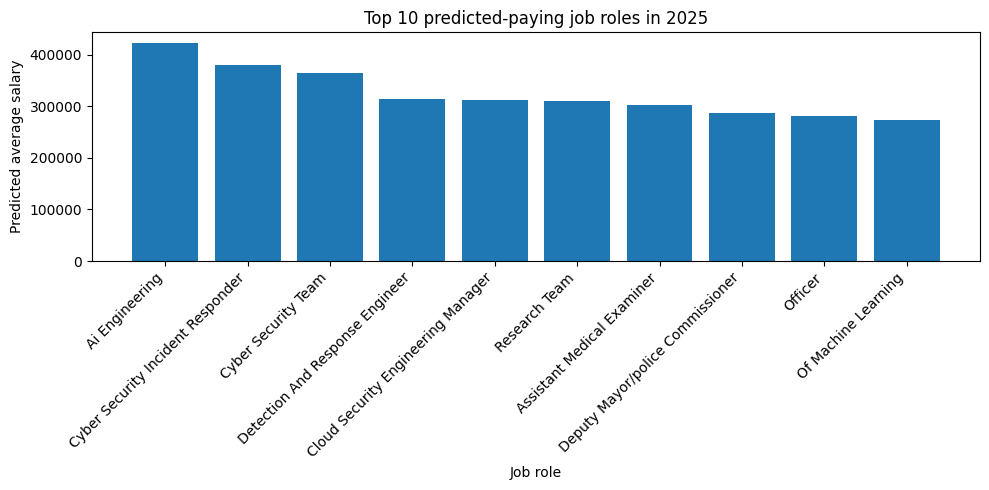

                             job_role  avg_pred_salary  idx
0                      Ai Engineering        422517.42    0
1   Cyber Security Incident Responder        379568.86    1
2                 Cyber Security Team        363885.03    2
3     Detection And Response Engineer        315058.39    3
4  Cloud Security Engineering Manager        312166.90    4


In [11]:
from pyspark.sql import functions as F
from pyspark.ml.pipeline import PipelineModel
import matplotlib.pyplot as plt

loaded_model = PipelineModel.load("data/PART_5_fill_with_more_data/salary_rf_model")
silver_agg_loaded = spark.read.parquet("data/PART_5_fill_with_more_data/silver_agg.parquet")
gold_detail_loaded = spark.read.parquet("data/PART_5_fill_with_more_data/gold_detail.parquet")

agg_for_join = silver_agg_loaded
if "occ_title" in agg_for_join.columns and "job_role" not in agg_for_join.columns:
    agg_for_join = agg_for_join.withColumnRenamed("occ_title", "job_role")
if "jobposition" in agg_for_join.columns and "job_role" not in agg_for_join.columns:
    agg_for_join = agg_for_join.withColumnRenamed("jobposition", "job_role")
if "companylocation" in agg_for_join.columns and "location" not in agg_for_join.columns:
    agg_for_join = agg_for_join.withColumnRenamed("companylocation", "location")
if "employeeresidence" in agg_for_join.columns and "location" not in agg_for_join.columns:
    agg_for_join = agg_for_join.withColumnRenamed("employeeresidence", "location")

ml_df = gold_detail_loaded

if "occ_title" in ml_df.columns and "job_role" not in ml_df.columns: ml_df = ml_df.withColumnRenamed("occ_title", "job_role")
if "jobposition" in ml_df.columns and "job_role" not in ml_df.columns: ml_df = ml_df.withColumnRenamed("jobposition", "job_role")
if "companylocation" in ml_df.columns and "location" not in ml_df.columns: ml_df = ml_df.withColumnRenamed("companylocation", "location")
if "employeeresidence" in ml_df.columns and "location" not in ml_df.columns: ml_df = ml_df.withColumnRenamed("employeeresidence", "location")
if "fiscal_year" in ml_df.columns and "year" not in ml_df.columns: ml_df = ml_df.withColumnRenamed("fiscal_year", "year")
if "senioritylevel" in ml_df.columns and "seniority_level" not in ml_df.columns: ml_df = ml_df.withColumnRenamed("senioritylevel", "seniority_level")
if "experienceyears" in ml_df.columns and "experience_years" not in ml_df.columns: ml_df = ml_df.withColumnRenamed("experienceyears", "experience_years")

join_cols = []
if "job_role" in ml_df.columns and "job_role" in agg_for_join.columns: join_cols.append("job_role")
if "location" in ml_df.columns and "location" in agg_for_join.columns: join_cols.append("location")

if join_cols:
    ml_df = ml_df.join(
        agg_for_join.select(
            *join_cols,
            "avg_salary",
            "min_salary",
            "max_salary",
            "salary_records"
        ),
        on=join_cols,
        how="left"
    )

if "experience_years" in ml_df.columns:
    ml_df = ml_df.withColumn("experience_years", F.col("experience_years").cast("double"))

ml_df = ml_df.dropna(subset=["job_role", "location", "year", "salary_clean"])

target_year = 2025

pred_input = ml_df.filter(F.col("year") == target_year)
predictions_year = loaded_model.transform(pred_input)

top_jobs_df = (
    predictions_year
    .groupBy("job_role")
    .agg(F.avg("prediction_salary").alias("avg_pred_salary"))
    .orderBy(F.desc("avg_pred_salary"))
    .limit(10)
)

top_jobs_pd = top_jobs_df.toPandas()

print("rows for plotting:", len(top_jobs_pd))

plt.figure(figsize=(10, 5))
plt.bar(top_jobs_pd["job_role"], top_jobs_pd["avg_pred_salary"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Predicted average salary")
plt.xlabel("Job role")
plt.title(f"Top 10 predicted-paying job roles in {target_year}")
plt.tight_layout()
plt.show()

top_jobs_pd = top_jobs_pd.reset_index(drop=True)
top_jobs_pd["idx"] = top_jobs_pd.index
top_jobs_pd["avg_pred_salary"] = top_jobs_pd["avg_pred_salary"].round(2)

top_jobs_pd.to_csv("data/top-jobs-2025.csv", index=False)

print(top_jobs_pd.head())
